# Machine Learning: Gold Price Prediction

*Table of Contents*:
- Importing Libraries
- Importing Data
- Time-Series Split
- Basic Machine Learning Model
- Feature Expansion
    - Lagged Features
    - SMA50 and SMA200
    - EMA50 and EMA200
    - S&P 500 and Crude Oil Futures Closing Price
    - RSI (14-period)
- More Advanced Model
- Manual Feature Optimization
- Hyperparameter Tuning
- Conclusions

**Objective**: Predict the **movement (up or down)** of the price of the IAU Gold ETF **on a weekly basis** by constructing and optimizing an appropriate Machine Learning Model.

## Importing Libraries

In [400]:
import yfinance as yf
import pandas as pd
pd.options.display.max_columns = 500
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from stockstats import StockDataFrame 
sns.set_style('ticks')
sns.color_palette("tab10")
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, root_mean_squared_error

## Importing Data

In [280]:
#Importing IAU Gold ETF price
gold = yf.Ticker("IAU").history(period="max")

In [281]:
gold.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,0.0,0.0
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,0.0,0.0
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,0.0,0.0
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,0.0,0.0
2005-02-03 00:00:00-05:00,8.316,8.348,8.302,8.344,534000,0.0,0.0,0.0
2005-02-04 00:00:00-05:00,8.320,8.332,8.284,8.300,433500,0.0,0.0,0.0
2005-02-07 00:00:00-05:00,8.314,8.314,8.250,8.270,938000,0.0,0.0,0.0
2005-02-08 00:00:00-05:00,8.256,8.282,8.218,8.258,880500,0.0,0.0,0.0
2005-02-09 00:00:00-05:00,8.218,8.272,8.208,8.268,404500,0.0,0.0,0.0


Since this gold comes from the `yfinance` library, it does not require any additional cleaning or formatting.

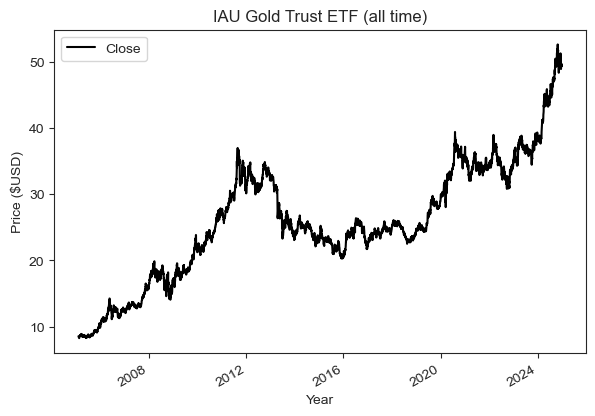

In [282]:
#Plotting close price history
gold.plot.line(y="Close", use_index=True, color='k')
plt.title("IAU Gold Trust ETF (all time)")
plt.tight_layout(pad=3)
plt.xlabel("Year")
plt.ylabel("Price ($USD)")
plt.savefig("images/GoldETF_All_Time.png", bbox_inches='tight')
plt.show()

In [283]:
#Removing unnecessary Dividends and Stock Splits columns
del gold["Dividends"]
del gold["Stock Splits"]

In [284]:
#Adding Next Week's price column
gold["Next week"] = gold["Close"].shift(-7)

The chart of our interest here is going to be the weekly chart. Our goal is to predict whether the price rises or falls next week, not necessarily it's exact value in the next week.

In [285]:
#Adding target column; 1 for price rise, 0 else
gold["Weekly Target"] = (gold["Next week"] > gold["Close"]).astype(int)

In [286]:
gold.head(4)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,8.258,0
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,8.268,0
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,8.362,0
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,8.424,0


In [287]:
gold.tail(1)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2024-12-27 00:00:00-05:00,49.360001,49.490002,49.299999,49.369999,2654200,0.0,NaN,0


It is well known that major market shifts (e.g. Black Swan events, financial crises, etc.) affect how our learning algorithm trains itself. In this project, we will pureposefully leave the 2008 financial crisis gold inside the training set. This is because gold is a relatively volatile instrument anyways, and its markets usually respond to unforseen geopolitical (or other) events.

## Time-Series Split

Before doing a Time Series Split, we will split the data into the main train/test sets. Each of the sets will get 50% of the data. Because this is a sequence model, splitting them in the traditional way (e.g. 80/20) will cause the test accuracy to be disproportionately higher than the training accuracy, leading us to falsely believe that our model is doing better than it actually is. This mistake was done in an earlier version of this project. 

In [363]:
#Splitting data into two main train/test sets
gold_train = gold.loc[:"2015-01-12"].sort_values(by="Date")
gold_test =  gold.loc["2015-01-12":].sort_values(by="Date")

In [364]:
gold_train

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258000,0
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268000,0
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362000,0
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424000,0
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524000,1
...,...,...,...,...,...,...,...,...
2015-01-06 00:00:00-05:00,23.440001,23.680000,23.340000,23.580000,4021950,0.0,24.360001,1
2015-01-07 00:00:00-05:00,23.480000,23.559999,23.400000,23.459999,1536000,0.0,24.700001,1
2015-01-08 00:00:00-05:00,23.480000,23.540001,23.340000,23.379999,925800,0.0,25.040001,1


In [365]:
#Initializing a TimeSeriesSplit generator for time-series cross-validation
time_ser_split = TimeSeriesSplit(n_splits=9, test_size=250, gap=0)
#Defining predictors
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']

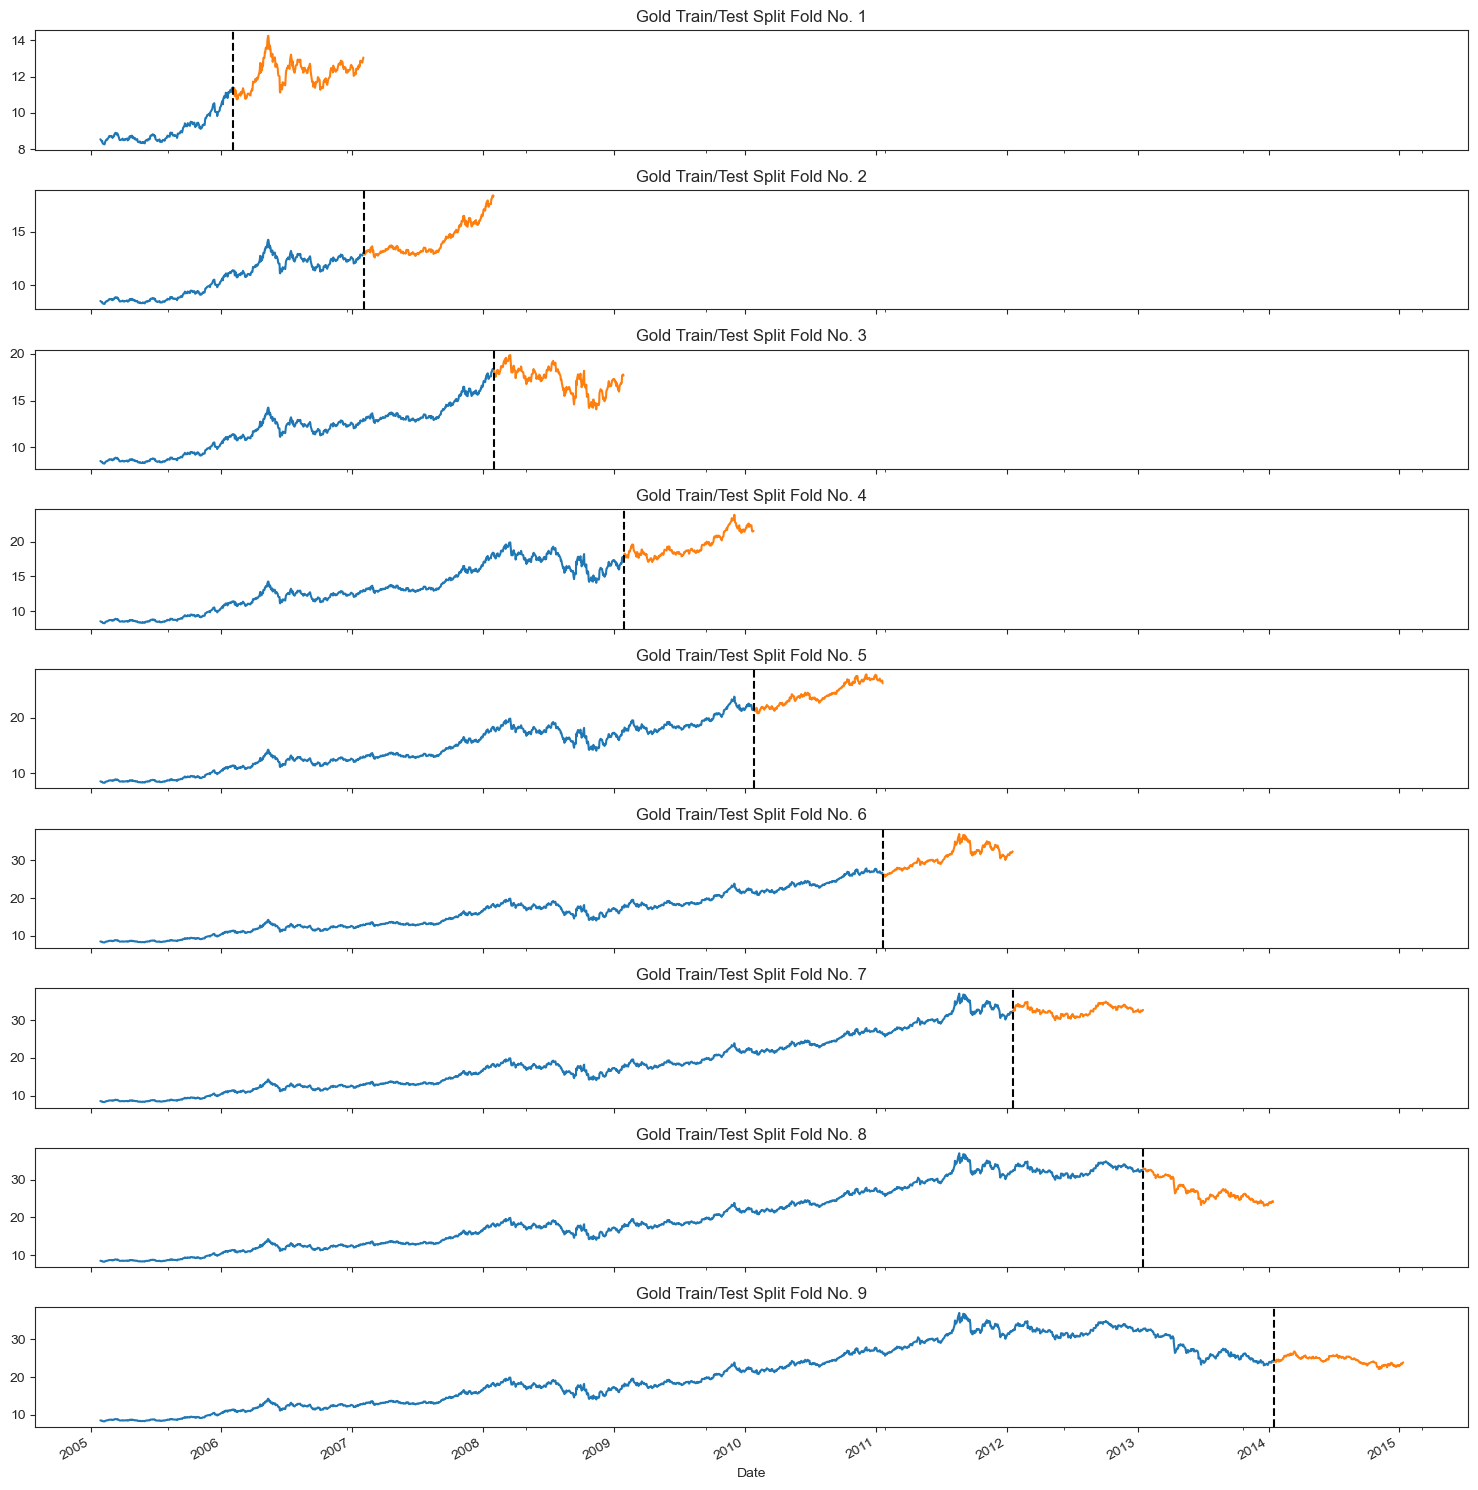

In [366]:
#Visualizing the time-series split
fig, ax = plt.subplots(9, 1, figsize=(15,15), sharex=True)

fold = 0
for train_index, test_index in time_ser_split.split(gold_train):
    train = gold_train.iloc[train_index]
    test = gold_train.iloc[test_index]
    train['Close'].plot(ax=ax[fold], label='Training Set', title=f'Gold Train/Test Split Fold No. {fold+1}')
    test['Close'].plot(ax=ax[fold], label='Test Set')
    ax[fold].axvline(test.index.min(), color='k', ls='--')
    fold += 1

plt.tight_layout()
plt.savefig('images/01_TimeSeriesSplit.png', bbox_inches='tight')
plt.show()

## Basic Machine Learning Model

The Classifier that is going to be used in this project is the Scikit-Learn RandomForestClassifier. Decision-tree based classifiers do well on time-series data. However, one must be careful not to overfeed or underfeed it with features.

In [367]:
#Building an initial Machine Learning Model
model = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=57)
results = cross_val_score(model, gold_train[predictors], gold_train["Weekly Target"], cv = time_ser_split)

In [368]:
#Score of basic model
print(f"Score of basic model: {(results).mean()}")

Score of basic model: 0.48711111111111116


In [369]:
#RMSE of basic model (this unfortunately requires fitting the model again)
model.fit(gold_train[predictors], gold_train["Weekly Target"])
preds = model.predict(gold_test[predictors])
RMSE_ = root_mean_squared_error(gold_test["Weekly Target"], preds)
print(f"RMSE of basic model: {RMSE_}\nMean of basic model: {gold_test["Weekly Target"].mean()}")

RMSE of basic model: 0.7068247844530251
Mean of basic model: 0.5350877192982456


In [370]:
#Percentage of days the price went up or down
gold_train["Weekly Target"].value_counts() / gold_train.shape[0]

Weekly Target
1    0.555866
0    0.444134
Name: count, dtype: float64

A score of 0.47 is not very good. Additionally, the RMSE is not only the same order of magnitude, but larger than the mean, which is indicative of a poor model. We would be better of going against the model when making predictions about price. Let us develop the model some more by adding more predicting features. Finally, the fraction of rising (0.556) Weekly Target values is larger than the model's accuracy, making it a safer bet to just always buy based on that fraction, instead of what the model says.

In [371]:
#Score on the Test Set
preds = pd.Series(preds, index=gold_test.index)
precision_score(gold_test["Weekly Target"], preds)

0.5362673186634067

## Feature Expansion

### Lagged Features

In [372]:
target_map = gold['Weekly Target'].to_dict()

In [373]:
def add_lag_features(data, predictors=None):
    data['lag1'] = (data.index-pd.Timedelta('364 days')).map(target_map)
    data['lag2'] = (data.index-pd.Timedelta('798 days')).map(target_map)
    data['lag3'] = (data.index-pd.Timedelta('1092 days')).map(target_map)
    #predictors += (['lag1', 'lag2', 'lag3'])
    return data

In [374]:
add_lag_features(gold_train, predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3
Date,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06 00:00:00-05:00,23.440001,23.680000,23.340000,23.580000,4021950,0.0,24.360001,1,1.0,NaN,1.0
2015-01-07 00:00:00-05:00,23.480000,23.559999,23.400000,23.459999,1536000,0.0,24.700001,1,1.0,NaN,1.0
2015-01-08 00:00:00-05:00,23.480000,23.540001,23.340000,23.379999,925800,0.0,25.040001,1,1.0,NaN,1.0


In [375]:
#Number of NaN values in lag2 column
gold_train["lag2"].isna().sum()

1338

KEEEP IN MIND THAT HERE WE ARE PREDICTING UP OR DOWN, NOOT PRICEE!!!! THAT'S WHY FEATURES ARE THE WAY THEY ARE

### SMA (50 and 200 Day)

In [376]:
def create_SMA(data, predictors=None):
    data["SMA50"] = data.rolling(window=50).mean()["Weekly Target"]
    data["SMA200"] = data.rolling(window=200).mean()["Weekly Target"]
    #predictors += ["SMA50", "SMA200"]
    return data

In [377]:
create_SMA(gold_train, predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200
Date,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06 00:00:00-05:00,23.440001,23.680000,23.340000,23.580000,4021950,0.0,24.360001,1,1.0,NaN,1.0,0.60,0.445
2015-01-07 00:00:00-05:00,23.480000,23.559999,23.400000,23.459999,1536000,0.0,24.700001,1,1.0,NaN,1.0,0.62,0.450
2015-01-08 00:00:00-05:00,23.480000,23.540001,23.340000,23.379999,925800,0.0,25.040001,1,1.0,NaN,1.0,0.64,0.455


### EMA (50 and 200 Day)

In [378]:
def create_EMA(data, predictors=None):
    data["EMA50"] = data.ewm(span=50).mean()["Weekly Target"]
    data["EMA200"] = data.ewm(span=200).mean()["Weekly Target"]
    #predictors += ["EMA50", "EMA200"]
    return data

In [379]:
create_EMA(gold_train, predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200
Date,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06 00:00:00-05:00,23.440001,23.680000,23.340000,23.580000,4021950,0.0,24.360001,1,1.0,NaN,1.0,0.60,0.445,0.621573,0.482757
2015-01-07 00:00:00-05:00,23.480000,23.559999,23.400000,23.459999,1536000,0.0,24.700001,1,1.0,NaN,1.0,0.62,0.450,0.636413,0.487903
2015-01-08 00:00:00-05:00,23.480000,23.540001,23.340000,23.379999,925800,0.0,25.040001,1,1.0,NaN,1.0,0.64,0.455,0.650671,0.492999


### S&P 500 and Crude Oil Futures Price Data

We introduce the S&P 500 ETF as another input feature of our classifier. It is commonly thought (and observed) that the value of this index is inversely proportional to the price of gold. We also include the Crude Oil Futures price data, as oil can be a good indicator for the state of the market.

In [380]:
def add_sp500_data(data, start, end, predictors=None):
    snp = yf.Ticker("^GSPC").history(start=start, end=end)
    data["S&P500 Close"] = snp["Close"].copy()
    del snp
    #predictors += ["S&P500 Close"]
    return data

def add_CLF_data(data, start, end, predictors=None):
    CLF = yf.Ticker("CL=F").history(start=start, end=end)
    data["CLF Close"] = CLF["Close"].copy()
    del CLF
    #predictors += ["CLF Close"]
    return data

In [381]:
add_sp500_data(gold_train, gold_train.index[0], gold_train.index[-1], predictors)
add_CLF_data(gold_train, gold_train.index[0], gold_train.index[-1], predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close
Date,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1171.359985,47.180000
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1181.270020,48.200001
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1189.410034,47.119999
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1193.189941,46.689999
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020,1189.890015,46.450001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06 00:00:00-05:00,23.440001,23.680000,23.340000,23.580000,4021950,0.0,24.360001,1,1.0,NaN,1.0,0.60,0.445,0.621573,0.482757,2002.609985,47.930000
2015-01-07 00:00:00-05:00,23.480000,23.559999,23.400000,23.459999,1536000,0.0,24.700001,1,1.0,NaN,1.0,0.62,0.450,0.636413,0.487903,2025.900024,48.650002
2015-01-08 00:00:00-05:00,23.480000,23.540001,23.340000,23.379999,925800,0.0,25.040001,1,1.0,NaN,1.0,0.64,0.455,0.650671,0.492999,2062.139893,48.790001


### RSI (14 Day)

In [382]:
def get_RSI(data, predictors=None):
    stock = StockDataFrame.retype(data)
    rsi = stock.get('rsi_14')
    data["RSI_14"] = rsi
    #predictors += ["RSI_14"]
    return data

In [383]:
get_RSI(gold_train, predictors)

,open,high,low,close,volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1171.359985,47.180000,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1181.270020,48.200001,0.000000
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1189.410034,47.119999,0.000000
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1193.189941,46.689999,17.990817
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020,1189.890015,46.450001,9.477470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-06 00:00:00-05:00,23.440001,23.680000,23.340000,23.580000,4021950,0.0,24.360001,1,1.0,NaN,1.0,0.60,0.445,0.621573,0.482757,2002.609985,47.930000,57.068033
2015-01-07 00:00:00-05:00,23.480000,23.559999,23.400000,23.459999,1536000,0.0,24.700001,1,1.0,NaN,1.0,0.62,0.450,0.636413,0.487903,2025.900024,48.650002,54.874196
2015-01-08 00:00:00-05:00,23.480000,23.540001,23.340000,23.379999,925800,0.0,25.040001,1,1.0,NaN,1.0,0.64,0.455,0.650671,0.492999,2062.139893,48.790001,53.400371


There is no point in calulating the MACD indicator, since it is a function of two different EMAs - it is therefore redundant. Calculating two different SMAs and EMAs might have been a redundancy in itself that only does harm to the model. Later on, while testing the model, we might remove one of them from the list of predictors.

In [384]:
gold_train.head(5)

,open,high,low,close,volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,8.258,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1171.359985,47.180000,NaN
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,8.268,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1181.270020,48.200001,0.000000
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,8.362,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1189.410034,47.119999,0.000000
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,8.424,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1193.189941,46.689999,17.990817
2005-02-03 00:00:00-05:00,8.316,8.348,8.302,8.344,534000,0.0,8.524,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.20402,1189.890015,46.450001,9.477470


In [385]:
#Adding all these features to the test set
add_lag_features(gold_test)
create_SMA(gold_test)
create_EMA(gold_test)
add_sp500_data(gold_test, gold_test.index[0], gold_test.index[-1])
add_CLF_data(gold_test, gold_test.index[0], gold_test.index[-1])
get_RSI(gold_test)

,open,high,low,close,volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2015-01-12 00:00:00-05:00,23.680000,23.920000,23.639999,23.879999,2050250,0.0,25.240000,1,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,2028.260010,46.070000,NaN
2015-01-13 00:00:00-05:00,23.980000,24.020000,23.740000,23.820000,1204450,0.0,25.040001,1,1.0,0.0,1.0,NaN,NaN,1.000000,1.000000,2023.030029,45.889999,0.000000
2015-01-14 00:00:00-05:00,24.000000,24.059999,23.760000,23.760000,3301300,0.0,24.780001,1,1.0,0.0,1.0,NaN,NaN,1.000000,1.000000,2011.270020,48.480000,0.000000
2015-01-15 00:00:00-05:00,24.260000,24.520000,24.240000,24.360001,5463850,0.0,25.059999,1,1.0,0.0,1.0,NaN,NaN,1.000000,1.000000,1992.670044,46.250000,84.811893
2015-01-16 00:00:00-05:00,24.520000,24.820000,24.520000,24.700001,2824650,0.0,24.879999,1,1.0,0.0,1.0,NaN,NaN,1.000000,1.000000,2019.420044,48.689999,89.991824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20 00:00:00-05:00,49.380001,49.680000,49.320000,49.500000,5019400,0.0,NaN,0,0.0,NaN,NaN,0.48,0.600,0.416664,0.565914,5930.850098,69.459999,45.846204
2024-12-23 00:00:00-05:00,49.410000,49.419998,49.209999,49.270000,4704500,0.0,NaN,0,NaN,NaN,0.0,0.46,0.600,0.400324,0.560283,5974.069824,69.239998,44.018505
2024-12-24 00:00:00-05:00,49.380001,49.419998,49.250000,49.389999,1216700,0.0,NaN,0,0.0,NaN,0.0,0.44,0.595,0.384625,0.554708,6040.040039,70.099998,45.244984


In [386]:
gold_test.head(5)

,open,high,low,close,volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2015-01-12 00:00:00-05:00,23.68,23.920000,23.639999,23.879999,2050250,0.0,25.240000,1,1.0,1.0,NaN,NaN,NaN,1.0,1.0,2028.260010,46.070000,NaN
2015-01-13 00:00:00-05:00,23.98,24.020000,23.740000,23.820000,1204450,0.0,25.040001,1,1.0,0.0,1.0,NaN,NaN,1.0,1.0,2023.030029,45.889999,0.000000
2015-01-14 00:00:00-05:00,24.00,24.059999,23.760000,23.760000,3301300,0.0,24.780001,1,1.0,0.0,1.0,NaN,NaN,1.0,1.0,2011.270020,48.480000,0.000000
2015-01-15 00:00:00-05:00,24.26,24.520000,24.240000,24.360001,5463850,0.0,25.059999,1,1.0,0.0,1.0,NaN,NaN,1.0,1.0,1992.670044,46.250000,84.811893
2015-01-16 00:00:00-05:00,24.52,24.820000,24.520000,24.700001,2824650,0.0,24.879999,1,1.0,0.0,1.0,NaN,NaN,1.0,1.0,2019.420044,48.689999,89.991824


## More Advanced Model

In [387]:
gold_train.rename(columns={"open":"Open", "high":"High", "low":"Low", "close":"Close", "volume":"Volume"}, inplace=True)
gold_test.rename(columns={"open":"Open", "high":"High", "low":"Low", "close":"Close", "volume":"Volume"}, inplace=True)

In [388]:
predictors = ['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'lag1',
 'lag2',
 'lag3',
 'SMA50',
 'SMA200',
 'EMA50',
 'EMA200',
 'S&P500 Close',
 'CLF Close',
 'RSI_14',]

In [389]:
#Building a more advanced Machine Learning Model
model2 = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=57)
results2 = cross_val_score(model2, gold_train[predictors], gold_train["Weekly Target"], cv = time_ser_split)

In [390]:
#Score of more advanced model
print(f"Score of more advanced model: {(results2).mean()}")

Score of more advanced model: 0.5777777777777777


In [391]:
#RMSE of advanced model (this unfortunately requires fitting the model again)
model2.fit(gold_train[predictors], gold_train["Weekly Target"])
preds2 = model2.predict(gold_test[predictors])
RMSE_ = root_mean_squared_error(gold_test["Weekly Target"], preds2)
print(f"RMSE of more advanced model: {RMSE_}\nMean of more advanced model: {gold_test["Weekly Target"].mean()}")

RMSE of more advanced model: 0.6164284638436829
Mean of more advanced model: 0.5350877192982456


In [392]:
#Score on the Test Set
preds2 = pd.Series(preds2, index=gold_test.index)
print(f"Test Set Score of Advanced Model: {precision_score(gold_test["Weekly Target"], preds2)}")

Test Set Score of Advanced Model: 0.6833176248821866


This model is substantially better, although the RMSE is still very high compared to the mean. After playing with the predictors in the list, it turns out that the removal of one of the SMA and EMA indicators, along with the removal of the S&P500, makes the model score even better. To make sure we're choosing the most optimal features, let us look through the performance of the model on all the possible combinations of currently existing predictors.

The above was **obviously a joke** :), because there are $2^{15} = 32,768$ possible feature sets. Fitting so many models is unfortunately not feasible.

## ~~Oopsie~~

### Feature Optimization

In [393]:
list(itertools.chain(*[itertools.combinations(predictors, i+1) for i in range(len(predictors))]))

[('Open',),
 ('High',),
 ('Low',),
 ('Close',),
 ('Volume',),
 ('lag1',),
 ('lag2',),
 ('lag3',),
 ('SMA50',),
 ('SMA200',),
 ('EMA50',),
 ('EMA200',),
 ('S&P500 Close',),
 ('CLF Close',),
 ('RSI_14',),
 ('Open', 'High'),
 ('Open', 'Low'),
 ('Open', 'Close'),
 ('Open', 'Volume'),
 ('Open', 'lag1'),
 ('Open', 'lag2'),
 ('Open', 'lag3'),
 ('Open', 'SMA50'),
 ('Open', 'SMA200'),
 ('Open', 'EMA50'),
 ('Open', 'EMA200'),
 ('Open', 'S&P500 Close'),
 ('Open', 'CLF Close'),
 ('Open', 'RSI_14'),
 ('High', 'Low'),
 ('High', 'Close'),
 ('High', 'Volume'),
 ('High', 'lag1'),
 ('High', 'lag2'),
 ('High', 'lag3'),
 ('High', 'SMA50'),
 ('High', 'SMA200'),
 ('High', 'EMA50'),
 ('High', 'EMA200'),
 ('High', 'S&P500 Close'),
 ('High', 'CLF Close'),
 ('High', 'RSI_14'),
 ('Low', 'Close'),
 ('Low', 'Volume'),
 ('Low', 'lag1'),
 ('Low', 'lag2'),
 ('Low', 'lag3'),
 ('Low', 'SMA50'),
 ('Low', 'SMA200'),
 ('Low', 'EMA50'),
 ('Low', 'EMA200'),
 ('Low', 'S&P500 Close'),
 ('Low', 'CLF Close'),
 ('Low', 'RSI_14')

## Manual Feature Optimization

Manually optimizing the feature selection:

In [394]:
predictors.remove("SMA200")
predictors.remove("EMA200")
predictors.remove("S&P500 Close")
predictors

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'lag1',
 'lag2',
 'lag3',
 'SMA50',
 'EMA50',
 'CLF Close',
 'RSI_14']

In [ ]:
#Building a Feature Optimized Machine Learning Model
model3 = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=57)
results3 = cross_val_score(model3, gold_train[predictors], gold_train["Weekly Target"], cv = time_ser_split)

#Score of the Feature Optimized model
print(f"Score of feature optimized model: {(results3).mean()}")

Score of feature optimized model: 0.5991111111111111


In [396]:
#RMSE of feature optimized model (this unfortunately requires fitting the model again)
model3.fit(gold_train[predictors], gold_train["Weekly Target"])
preds3 = model3.predict(gold_test[predictors])
RMSE_ = root_mean_squared_error(gold_test["Weekly Target"], preds3)
print(f"RMSE of feature optimized model: {RMSE_}\nMean of more advanced model: {gold_test["Weekly Target"].mean()}")

RMSE of feature optimized model: 0.5859193079313043
Mean of more advanced model: 0.5350877192982456


In [397]:
print(f"Test Set Score of Feature Optimized Model: {precision_score(gold_test["Weekly Target"], preds3)}")

Test Set Score of Feature Optimized Model: 0.7754868270332188


The Test Set Score between the feature unoptimized and optimized models is substantial. The model is performing suspiciously well even before hyperparameter tuning. The reason must be because the model was trained on much harder data (e.g. the 2008 Financial Crisis).

## Hyperparameter Tuning

After developing the model thus far using feature optimization, we attempt to give its score one final boost by proper hyperparameter tuning.

In [404]:
parameters = { 
    'n_estimators': [1000, 1500, 2000], 
    'max_depth': [None, 3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9, None], 
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [50, 100, 150]
}


def find_best_algorithm(X, y):
    scores = {}

    gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=time_ser_split)
    gs.fit(X,y)
    scores.update({
        'Best Score': gs.best_score_,
        'Best Parameters': gs.best_params_,
        'Best RMSE': np.sqrt(mean_squared_error(y, gs.predict(X)))
    })
    return pd.DataFrame(scores, columns=['Best Score', 'Best Parameters', 'Best RMSE']).sort_values(by='Best RMSE', ascending=False)

In [406]:
best_model_df = find_best_algorithm(gold_train[predictors], gold_train["Weekly Target"])

KeyboardInterrupt: 

In [ ]:
#Results of Final Model on the Test Set
model4 = RandomForestClassifier(n_estimators=, min_samples_split=, random_state=57)
model4.fit(gold_train[predictors], gold_train["Weekly Target"])
preds4 = model4.predict(gold_test[predictors])
print(f"Test Set Score of Feature Optimized Model: {precision_score(gold_test["Weekly Target"], preds4)}")

A Randomized Search would perhaps been more optimal. This completes our SK-Learn Gold Price (Movement) Prediction Model.

## Conclusions

We can wrap up our project by noting the key takeaways:
- An equal fraction of data in the train and test sets ensured that test performance would not be disproportionately better than the training set
- Feature Expansion (`SMA50`, `SMA200`, `EMA50`, `EMA200`, `lag1`, `lag2`, `lag3`, `RSI`-14, `S&P500 Close`, `CL=F Close`), excepting the redundant `SMA200` and `EMA200`, as well as the `S&P500 Close`, contributes to better model performance.
- This model was classifying the price movement (0/1) between the next and current week. It did not predict Gold's closing price itself, which could have been done, and would have perhaps worked better.
- The model performs well, with a test set accuracy of ----
- It is thought that the good performance of the model is due to it being trained on data corresponding to big market shifts (e.g. the 2008 Financial Crisis)

Possible additions:
- Use ratios instead of Open/High/Low/Close so as to allow the model to generalize better to new data and not treat certain values of these parameters as hard-set, absolute boundaries
- Close Price Regression and Hyperparameter tuning, not just Weekly Price Movement Classification
- Smart Money Indicator (Retail Sentiment)
- Feeding the Model the past 10 days' worth of information for each training example (i.e. 10x more columns)
- Related Index Close Price from an exchange that is open during the NYSE's night hours
- News
- Resolution Increase